In [1]:
# Cell 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pandas'

In [14]:
# Load dataset
df = pd.read_csv('https://github.com/adepanjaitan23/Prediksi-data-naive-bayes-manual/issues/1#issue-2806503509')

# Prepare features and target
X = df[['KodePelanggan', 'JumlahPembelian', 'IntervalWaktu', 'Lokasi']]
y = df['Target']


In [16]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
class NaiveBayesCustomerPotential:
    def __init__(self):
        self.class_probabilities = {}
        self.feature_probabilities = {}
        self.label_encoders = {}

    def encode_categorical_features(self, X):
        """Encode categorical features"""
        X_encoded = X.copy()
        for column in X.columns:
            le = LabelEncoder()
            X_encoded[column] = le.fit_transform(X[column])
            self.label_encoders[column] = le
        return X_encoded

    def encode_input_features(self, X):
        """Encode input features, handle unknown values"""
        X_encoded = X.copy()
        for column, le in self.label_encoders.items():
            if column in X_encoded.columns:
                X_encoded[column] = X_encoded[column].map(
                    lambda x: le.transform([x])[0] if x in le.classes_ else -1
                )
        return X_encoded

    def fit(self, X, y):
        """Train Naive Bayes Classifier"""
        # Encode categorical features
        X_encoded = self.encode_categorical_features(X)

        # Calculate class probabilities
        unique_classes = y.unique()
        total_samples = len(y)

        for cls in unique_classes:
            # Class probability
            class_count = (y == cls).sum()
            self.class_probabilities[cls] = class_count / total_samples

            # Feature probabilities for each class
            X_class = X_encoded[y == cls]
            class_feature_probs = {}

            for feature in X_encoded.columns:
                # Calculate mean and standard deviation for each feature
                feature_mean = X_class[feature].mean()
                feature_std = X_class[feature].std()
                class_feature_probs[feature] = (feature_mean, feature_std)

            self.feature_probabilities[cls] = class_feature_probs

    def gaussian_probability(self, x, mean, std):
        """Calculate Gaussian probability"""
        if std == 0:
            return 1 if x == mean else 0
        exponent = np.exp(-((x - mean) ** 2) / (2 * (std ** 2)))
        return exponent / (np.sqrt(2 * np.pi) * std)

    def predict_proba(self, X):
        """Predict probabilities for each class"""
        probabilities = {}

        # Encode input features
        X_encoded = self.encode_input_features(X)

        for cls in self.class_probabilities.keys():
            # Start with log of class probability
            log_prob = np.log(self.class_probabilities[cls])

            # Calculate likelihood for each feature
            for feature in X_encoded.columns:
                mean, std = self.feature_probabilities[cls][feature]
                x = X_encoded[feature].values[0]

                # Handle unknown values (-1)
                if x == -1:
                    continue

                # Use log probability to prevent underflow
                log_prob += np.log(self.gaussian_probability(x, mean, std) + 1e-10)

            probabilities[cls] = np.exp(log_prob)

        # Normalize probabilities
        total_prob = sum(probabilities.values())
        probabilities = {k: v / total_prob for k, v in probabilities.items()}

        return probabilities

    def predict(self, X):
        """Predict the most likely class"""
        probas = self.predict_proba(X)
        return max(probas, key=probas.get)

In [18]:
# Train Naive Bayes classifier
nb_classifier = NaiveBayesCustomerPotential()
nb_classifier.fit(X_train, y_train)

In [19]:
# Accuracy Calculation
y_train_pred = X_train.apply(lambda row: nb_classifier.predict(pd.DataFrame([row])), axis=1)
y_test_pred = X_test.apply(lambda row: nb_classifier.predict(pd.DataFrame([row])), axis=1)

In [20]:
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Train Accuracy: 92.50%
Test Accuracy: 70.00%


<ipython-input-21-2556f0b32a93>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='Blues')


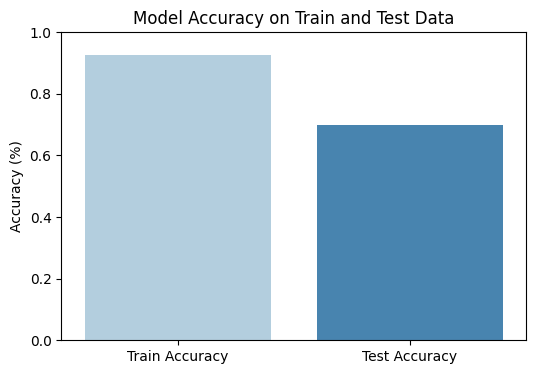

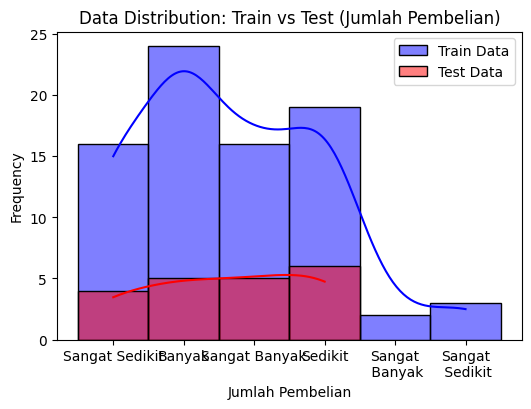

In [21]:
# Visualize accuracy
accuracies = {'Train Accuracy': train_accuracy, 'Test Accuracy': test_accuracy}

plt.figure(figsize=(6, 4))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()), palette='Blues')
plt.title("Model Accuracy on Train and Test Data")
plt.ylabel("Accuracy (%)")
plt.ylim(0, 1)
plt.show()

# Visualize data distribution of 'Jumlah Pembelian'
plt.figure(figsize=(6, 4))
sns.histplot(X_train['JumlahPembelian'], kde=True, label='Train Data', color='blue')
sns.histplot(X_test['JumlahPembelian'], kde=True, label='Test Data', color='red')
plt.title("Data Distribution: Train vs Test (Jumlah Pembelian)")
plt.xlabel("Jumlah Pembelian")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [26]:
# User Interaction: Customer Potential Prediction
while True:
    print("\n🔍 Customer Potential Prediction System")
    kode_pelanggan = input("Enter Customer Code (e.g., P1): ")
    jumlah_pembelian = input("Purchase Amount (Sangat Sedikit/Sedikit/Banyak/Sangat Banyak): ")
    interval_waktu = input("Purchase Interval (Harian/Mingguan): ")
    lokasi = input("Location (Dekat/Jauh): ")

    # Create input dataframe
    input_data = pd.DataFrame({
        'KodePelanggan': [kode_pelanggan],
        'JumlahPembelian': [jumlah_pembelian],
        'IntervalWaktu': [interval_waktu],
        'Lokasi': [lokasi]
    })

    # Predict
    try:
        prediction = nb_classifier.predict(input_data)
        probabilities = nb_classifier.predict_proba(input_data)

        print("\n📊 Prediction Results:")
        print(f"Customer Code: {kode_pelanggan}")
        print(f"Potential Status: {prediction}")
        print("Probabilities:")
        for cls, prob in probabilities.items():
            print(f"{cls}: {prob * 100:.2f}%")

    except Exception as e:
        print(f"Error during prediction: {e}")

    cont = input("Do you want to predict another customer? (yes/no): ").strip().lower()
    if cont != 'yes':
        break



🔍 Customer Potential Prediction System
Enter Customer Code (e.g., P1): P9889
Purchase Amount (Sangat Sedikit/Sedikit/Banyak/Sangat Banyak): Banyak
Purchase Interval (Harian/Mingguan): Harian
Location (Dekat/Jauh): Jauh

📊 Prediction Results:
Customer Code: P9889
Potential Status: Berpotensi
Probabilities:
Tidak Berpotensi: 0.00%
Berpotensi: 100.00%
Do you want to predict another customer? (yes/no): no
